## Zero/One/Few-Shot Learning

Zero-, one- and few-shot learning are techniques that allow a machine learning model to make predictions for new classes with limited labeled data.

<em>One-shot learning</em> implies that there is one labeled example per class. The goal is to make predictions for the new classes based on this single example.

<em>Few-shot learning</em> implies that there are a few labeled examples per class. The goal for model is to make predictions based on a few examples of labeled data.

<em>Zero-shot learning</em> implies there is not labeled data available. The goal is for the algorithm to make predictions about new classes by using prior knowledge about the relationships that exist between classes it already knows.

All these approches use some pre-trained Large Language Models as the base model. These models already have some knowledge of language structure and semantics.

These types of learning resemble transfer learning, however, the key difference between them is that transfer learning uses pre-trained model as a base for another, task-specific model.

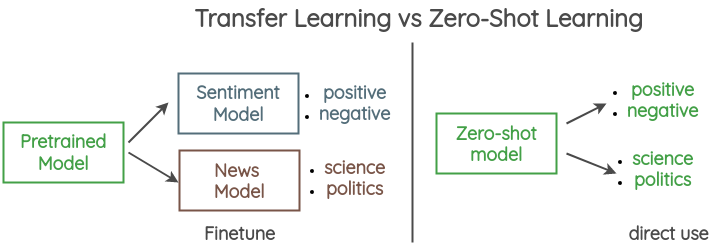

## Zero-Shot Text Classification

In this notebook we'll test a zero-shot classification approach on our shortened version of the emails dataset contaning 6 categories:
<ol>
<li>Rechungen
<li>Storno
<li>Mahnungen
<li>Tarife
<li>Aktivierung Sim
<li>Vertraege und Vereinbarung
</ol>

We'll use the transformers library for the task which requires tensorflow version >= 2.14.

In [1]:
# !pip install tensorflow==2.15.0

In [2]:
import tensorflow as tf

# if version >= 2.14 proceed
tf.__version__

'2.15.0'

## Data pre-processing

### Manage directories

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/emails/csv_datasets

/content/drive/MyDrive/emails/csv_datasets


In [5]:
ls

df.csv  full_dataset.csv  short_dataset.csv


In [6]:
import pandas as pd

df = pd.read_csv('short_dataset.csv')

In [7]:
# Check null values in df
df.isna().any()

Unnamed: 0    False
Category      False
Content       False
dtype: bool

In [8]:
df.head()

,Unnamed: 0,Category,Content
0,0,TARIFE,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t0...
1,1,TARIFE,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t3...
2,2,TARIFE,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...
3,3,TARIFE,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...
4,4,TARIFE,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t3...


In [9]:
df = df.drop('Unnamed: 0', axis=1)

In [10]:
# check the shape of df: (rows, columns)
df.shape

(365, 2)

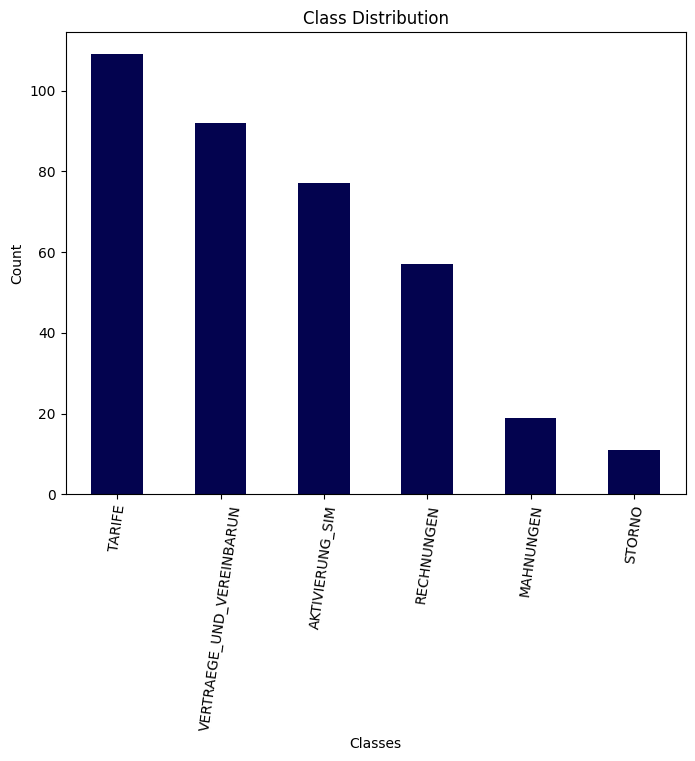

In [14]:
# class distribution

import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = df['Category'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=(0.01,0.01,0.31))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=82)  # Rotate x-axis labels if needed
plt.show()

In [15]:
import quopri

def decode_quoted_printable(text: str):
    """
    Decodes text using latin1 encoding.
    It allows to correctly decode German special characters (vowels with diacritics and ß)

    Args:
      text (str): incorrectly decoded German text.

    Returns:
      text (str): correctly decoded German text using latin-1 encoding.
    """

    if isinstance(text, str):
        try:
            # Convert string to bytes, decode using quopri, and then decode to iso-8859-1
            decoded = quopri.decodestring(text.encode('latin1')).decode('iso-8859-1')
            return decoded
        except Exception as e:
            return str(e)
    return text


# apply decoding function to the 'Content' column and save result to 'Content_fixed' column
df['Content_fixed'] = df['Content'].apply(decode_quoted_printable)

In [18]:
import re

def fetch_body(text: str):
    """
    Fetches the email body (the message itself).
    Takes email, extracts the email body and cleans it by normalizing spaces.

    Args:
      text (str): raw email text.

    Returns:
      text (str): email body with no newlines and extra spaces.
    """

    text = text.split("Nachricht      : ")[-1]
    text = text.split("--")[0]
    text = re.sub("\n", " ", text)
    text = re.sub(" +", " ", text)
    text = re.sub(r"\s+([.,!?])", r"\1", text)
    return text.strip()


# apply fetch_body function to 'Content_fixed' column and dave the result to 'Email_body' column
df['Email_body'] = df['Content_fixed'].apply(fetch_body)

In [20]:
random_sentence = df['Email_body'][44]
random_sentence

'Sehr geehrtes E-Plus Team, in welchem Ihrer Tarife ist die automatische Rufumleitung auf ein anders Handy kostenfrei? Mit freundlichen Grüßen Dallmann Stephanie'

Now it looks like a normal text.

For this task we don't need to further preprocess our text data which was what we did when we used traditional ML (Linear SVC, Multinomial NB, Random Forest) and Flair model for few-shot learning. We can pass a normal string containing punctuation, words in different case, numbers etc. to a pre-trained model like GPT or BERT.

In [21]:
# check unique categories
df['Category'].unique()

array(['TARIFE', 'RECHNUNGEN', 'MAHNUNGEN', 'STORNO', 'AKTIVIERUNG_SIM',
       'VERTRAEGE_UND_VEREINBARUN'], dtype=object)

In [22]:
# rename categories to make them more zero-shot-classification-friendly :)
df['Category'] = df['Category'].map({'RECHNUNGEN': 'Rechnungen', 'TARIFE': 'Tarife', 'STORNO': 'Storno', 'MAHNUNGEN': 'Mahnungen', 'VERTRAEGE_UND_VEREINBARUN': 'Verträge und Vereinbarungen', 'AKTIVIERUNG_SIM':'SIM-Karte Aktivierung'})

In [23]:
# shuffle df
df = df.sample(frac=1).reset_index(drop=True)

In [24]:
df.head()

,Category,Content,Content_fixed,Email_body
0,Rechnungen,An:\tKUNDENSERVICE@EPLUS\nKopie:\tkatrinheinri...,An:\tKUNDENSERVICE@EPLUS\nKopie:\tkatrinheinri...,An:\tKUNDENSERVICE@EPLUS Kopie:\tkatrinheinric...
1,SIM-Karte Aktivierung,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t1...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t1...,ich möchte eine neue rufnummer nach meinen wun...
2,Tarife,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,Ich möchte meinen Vertrag auf den Studententar...
3,Rechnungen,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,"Sehr geehrte Damen und Herren, die oben angege..."
4,Verträge und Vereinbarungen,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t3...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t3...,"Hallo, ich würde gern was mich das das Samsung..."


In [36]:
labels = list(df['Category'].unique())
labels

['Rechnungen',
 'SIM-Karte Aktivierung',
 'Tarife',
 'Verträge und Vereinbarungen',
 'Mahnungen',
 'Storno']

Models we'll use for zero-shot classification: <br>

<center>

| Model | Base model  |
|:---:|:---:|
| German_zeroshot | GBERT Large |
| bart-large-mnli| BART |
| DistilBart-MNLI| BART |
| Gbert Large Zeroshot Nli | GBERT Large |
| German-GPT2| GPT-2 |

</center>

## Template functions for zero-shot classification

In [27]:
def load_model(pre_trained_model_name: str):
  """
  Loads model from huggingface and creates pipeline for zero-shot-classification task.

  Args:
    pre_trained_model (str): name of huggingface pre-trained model.

  Returns:
    classifier (transformers.pipelines.zero_shot_classification.ZeroShotClassificationPipeline):
      pipeline for zero-shot-classification using chosen pre-trained model.

  """

  from transformers import pipeline

  classifier = pipeline("zero-shot-classification",
                      model=pre_trained_model_name)

  return classifier

def display_confusion_matrix(predicted: list, actual: list, labels: list):
  """
  Visualizes confusion matrix.

  Args:
    predicted (list): list of predicted labels for input emails;
    actual (list): list of actual labels for input emails;
    labels (list): list of categories (6 overall).

  Returns:
    6*6 (because 6 categories) confusion matrix visualizing model performance.

  """

  from sklearn import metrics

  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                              display_labels=labels)

  cm_display.plot()
  plt.xticks(rotation=270)
  plt.show()


def predict_label_first_10(labels_list: list, classifier_model):
  """
  Prints first 10 emails with their actual and predicted category values.
  Preliminary assessment of the model's capabilities

  Args:
    labels_list (list): list of categories for prediction (6 categories overall).
    classifier_model (transformers.pipelines.zero_shot_classification.ZeroShotClassificationPipeline):
      pipeline for zero-shot-classification using chosen pre-trained model.

  Prints:
    Email number, email content, predicted and actual category of the email.

  """

  candidate_labels = labels_list

  for ind, row in df.head(10).iterrows():

    sequence = row['Email_body']

    prediction = classifier_model(sequence, candidate_labels)

    # fetch predicted value
    pred = str(prediction['labels'][0])

    # fetch the actual value
    act = str(row['Category'])

    print(f"{ind+1}. Email: {sequence}")
    print(f"   Predicted label: {pred}; Actual label: {act}\n")


def predict_label_full_dataset(labels_list: list, classifier_model):
  """
  Predicts category for all emails from the given category list (labels_list)
  using pre-trained model (classifier_model).

  Args:
    labels_list (list): list of categories for prediction (6 categories overall).
    classifier_model (transformers.pipelines.zero_shot_classification.ZeroShotClassificationPipeline):
      pipeline for zero-shot-classification using chosen pre-trained model.

  Returns:
    predicted (list): list of predicted categories;
    actual (list): list of actual values.

  """

  candidate_labels = labels_list

  # define empty lists to further calculate model accuracy
  predicted = []
  actual = []

  for ind, row in df.iterrows():

    sequence = row['Email_body']

    prediction = classifier_model(sequence, candidate_labels)

    # fetch predicted value
    pred = str(prediction['labels'][0])

    # fetch the actual value
    act = str(row['Category'])

    # append predicted and actual values
    actual.append(act)
    predicted.append(pred)

  return predicted, actual


def calculate_accuracy(predicted_labels: list, actual_labels: list):
  """
  Calculates accuracy of the model for email classification.

  Args:
    predicted_labels (list): list of predicted labels;
    actual_labels (list): list of actual values.

  Returns:
      accuracy (str): model accuracy as a percentage

  """

  correct_predictions = sum(p == a for p, a in zip(predicted_labels, actual_labels))
  total_predictions = len(predicted_labels)
  accuracy = correct_predictions / total_predictions
  accuracy = f"{accuracy * 100:.0f}%"
  return accuracy

## Zero-shot classification using <a href="https://huggingface.co/Sahajtomar/German_Zeroshot">German-Zeroshot<a>

In [28]:
classifier = load_model("Sahajtomar/German_Zeroshot")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/823 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Let's predict email categories for the first 10 emails in our DataFrame:

In [30]:
predict_label_first_10(
    labels,
    classifier
)

1. Email: An:	KUNDENSERVICE@EPLUS Kopie:	katrinheinrich@aol.com Datum:	17.11.2001 21:00:25 Betreff:	(no subject) 	 Sehr geehrte Damen und Herren, da nun schon wieder eine Monatsrate abgebucht wurde, bitte ich um umgehende Bearbeitung der Anfrage.Siehe auch Ihr email vom 15.08.01!!! Meine Kundennummer ist 1711357 meine Rufnummer ist 0177-7181916 Der Vertrag wurde ca. April 1999 in Hameln oder Goettingen abgeschlossen. Sollten Pobleme auftreten, so kontaktieren Sie mich bitte umgehend. Die Gutschrift von DM 60 kann auf folgendes Konto erfolgen: Katrin Heinrich, SK Weserbergland, BLZ 25450110 Kto 100221498, von diesem wurde auch die monatliche Rate abgebucht. Vielen Dank fuer ihre Bemuehungen Katrin Hinrich
   Predicted label: Verträge und Vereinbarungen; Actual label: Rechnungen

2. Email: ich möchte eine neue rufnummer nach meinen wunschen: wunschrufnummern (vorschläge) - 0163/2090090 - 0178/2090090 - 0177/1090090 oder 20.. 30.. usw - 0177/2090091 oder 0177/2090089 bitte teilen sie mir 

In [ ]:
predicted, actual = predict_label_full_dataset(
    labels,
    classifier
)

In [ ]:
print(f"Accuracy of the German-Zeroshot classifier: {calculate_accuracy(predicted, actual)}")

Accuracy of the German-Zeroshot classifier: 42%


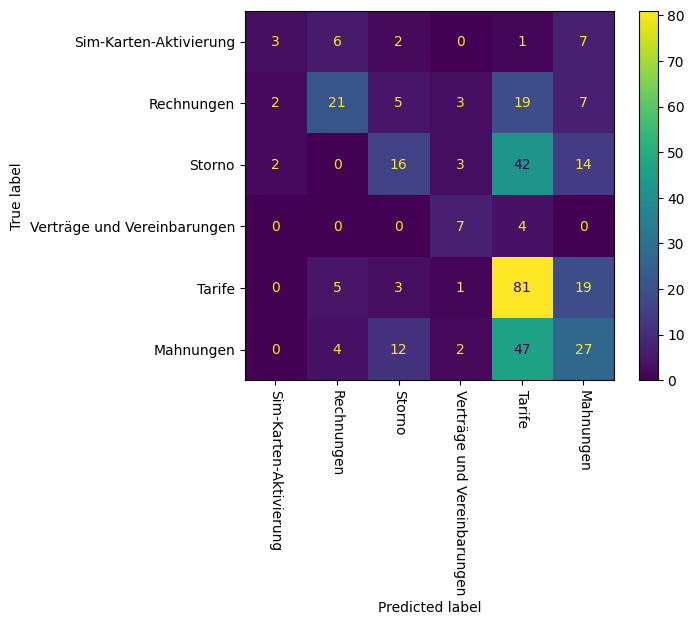

In [ ]:
display_confusion_matrix(predicted, actual, ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"])

The problem I encountered while trying out pre-trained models for zero-chot classification is that Class Description plays huge role for correct text labeling by the model. Initially, the model wasn't able to detect the emails belonging to the category "Aktivierung der SIM-Karte" and was assigning the label "Tarif", but when I changed the class name to "Sim-Karte Aktivierung" it started capturing it. Also, the model overfits on some more general classes like "Tarife" and "Vertrage and Vereinbarungen" while failing to capture the essence of more specific classes like "Sim-Karten-Aktivierung" and "Mahnungen"

## Zero-shot classification using <a href="https://huggingface.co/facebook/bart-large-mnli">bart-large-mnli</a>

In [38]:
bart_mnli = load_model('facebook/bart-large-mnli')

In [39]:
labels = ['Mahnungen', 'Rechnungen', 'SIM-Karte Aktivierung', 'Storno', 'Tarife', 'Vertraege']
labels

['Mahnungen',
 'Rechnungen',
 'SIM-Karte Aktivierung',
 'Storno',
 'Tarife',
 'Vertraege']

In [40]:
predict_label_first_10(
    labels,
    bart_mnli
)

1. Email: An:	KUNDENSERVICE@EPLUS Kopie:	katrinheinrich@aol.com Datum:	17.11.2001 21:00:25 Betreff:	(no subject) 	 Sehr geehrte Damen und Herren, da nun schon wieder eine Monatsrate abgebucht wurde, bitte ich um umgehende Bearbeitung der Anfrage.Siehe auch Ihr email vom 15.08.01!!! Meine Kundennummer ist 1711357 meine Rufnummer ist 0177-7181916 Der Vertrag wurde ca. April 1999 in Hameln oder Goettingen abgeschlossen. Sollten Pobleme auftreten, so kontaktieren Sie mich bitte umgehend. Die Gutschrift von DM 60 kann auf folgendes Konto erfolgen: Katrin Heinrich, SK Weserbergland, BLZ 25450110 Kto 100221498, von diesem wurde auch die monatliche Rate abgebucht. Vielen Dank fuer ihre Bemuehungen Katrin Hinrich
   Predicted label: Vertraege; Actual label: Rechnungen

2. Email: ich möchte eine neue rufnummer nach meinen wunschen: wunschrufnummern (vorschläge) - 0163/2090090 - 0178/2090090 - 0177/1090090 oder 20.. 30.. usw - 0177/2090091 oder 0177/2090089 bitte teilen sie mir schnellstmöglich m

### Test bart model without any preprocessing and synonyms usage

In [ ]:
predicted, actual = predict_label_full_dataset(
    labels,
    bart_mnli
)

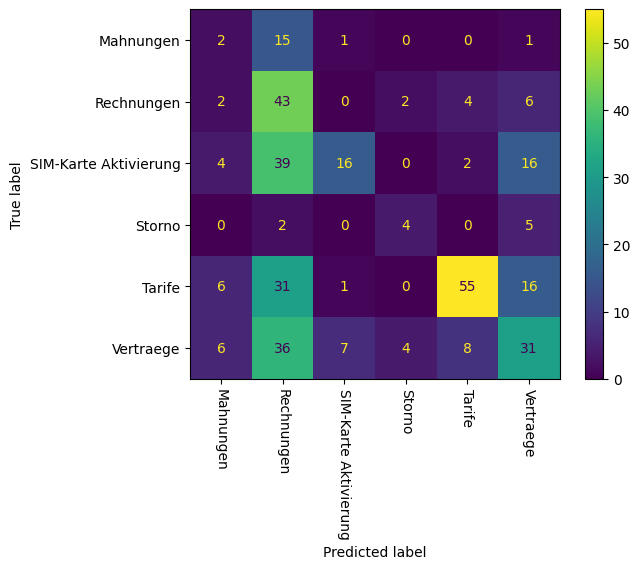

In [ ]:
display_confusion_matrix(predicted,
                         actual,
                         ['Mahnungen', 'Rechnungen', 'SIM-Karte Aktivierung', 'Storno', 'Tarife', 'Vertraege'])

In [ ]:
print(calculate_accuracy(predicted, actual))

41%


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(predicted, actual))

                             precision    recall  f1-score   support

                  Mahnungen       0.11      0.10      0.10        20
                 Rechnungen       0.75      0.26      0.39       166
      SIM-Karte Aktivierung       0.21      0.64      0.31        25
                     Storno       0.36      0.40      0.38        10
                     Tarife       0.50      0.80      0.62        69
Verträge und Vereinbarungen       0.34      0.41      0.37        75

                   accuracy                           0.41       365
                  macro avg       0.38      0.43      0.36       365
               weighted avg       0.54      0.41      0.41       365



### Test using synonyms

In [42]:
# Define candidate labels with synonyms

labels_with_synonyms = {
    "Rechnungen": ["Rechnungen", "Fakturen", "Abrechnung", "Monatsabrechnung"],
    "SIM-Karte Aktivierung": ["SIM-Karte Aktivierung", "SIM-Aktivierung", "Freischaltung von SIM-Karten", "SIM-Karte Deaktivierung"],
    "Storno": [ "Abbruch", "Storno", "Vertragskündigung", "Vertragsauflösung", "Auftragsstornierung"],
    "Verträge und Vereinbarungen": ["Vertragsabschluss", "Vertrag oder Vereinbarung", "Vertrag", "Kontrakt"],
    "Tarife": ["Tarifvergleich", "Tarifdetails", "Tarifänderung", "Tarifplan", "Tarif"],
    "Mahnungen": ["Mahnung", "Mahnbescheid", "Zahlungserinnerung"]
}

# Extract all synonyms for candidate labels
candidate_labels = sum(labels_with_synonyms.values(), [])

actual = []
predicted = []

for ind, row in df.iterrows():

  # Your input text
  input_text = row['Email_body']
  # Perform zero-shot classification
  result = bart_mnli(input_text, candidate_labels)

  # Map predicted labels back to original classes
  predicted_labels = []
  for label in result["labels"]:
      for key, synonyms in labels_with_synonyms.items():
          if label in synonyms:
              predicted_labels.append(key)
              break

  act = str(row['Category'])
  pred = predicted_labels[0]

  actual.append(act)
  predicted.append(pred)



  print(f"{ind+1}. {input_text}\n   Predicted: {pred}, Actual: {act}")

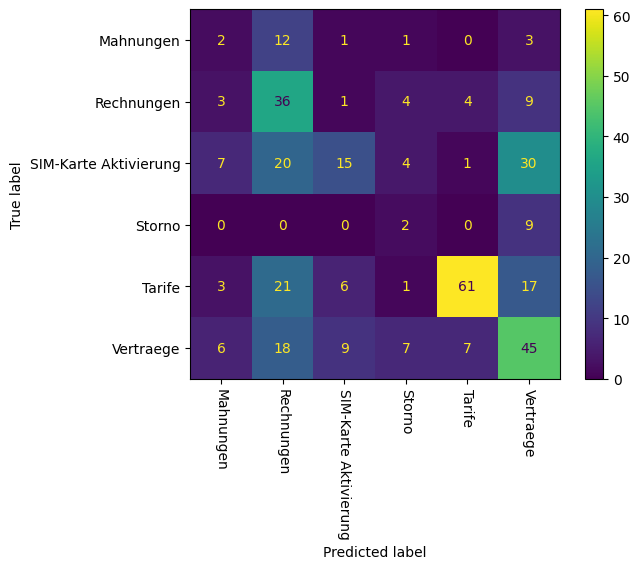

In [ ]:
display_confusion_matrix(predicted,
                         actual,
                         ['Mahnungen', 'Rechnungen', 'SIM-Karte Aktivierung', 'Storno', 'Tarife', 'Vertraege'])

In [ ]:
print(calculate_accuracy(predicted, actual))

48%


### Test using multi-label classification

In [57]:
from transformers import pipeline

model = 'facebook/bart-large-mnli'

# Pipeline abstraction from hugging face
pipe = pipeline(task='zero-shot-classification', model=model, tokenizer=model)

# Example sentence to be classified
# Actual label - SIM-Karte Aktivierung, predicted label - Rechnungen
test_txt = "ich möchte eine neue rufnummer nach meinen wunschen: wunschrufnummern (vorschläge) - 0163/2090090 - 0178/2090090 - 0177/1090090 oder 20.. 30.. usw - 0177/2090091 oder 0177/2090089 bitte teilen sie mir schnellstmöglich mit, ob diese nummern noch frei sind und wie ich sie bekomme"

# Define candidate labels (email topics)
topics = ['Vertrage', 'Tarife', 'Storno', 'Rechnungen', 'SIM-Karte Aktivierung', 'Mahnungen']

# Run pipeline with a test case
prediction = pipe(test_txt, topics, multi_label=True)

# Top 3 topics as predicted in zero-shot regime
print(f'Zero-shot prediction for: \n{prediction["sequence"]}')
# top_3 = zip(prediction['labels'][0:3], prediction['scores'][0:3])
top_3 = zip(prediction['labels'], prediction['scores'])

for label, score in top_3:
    print(f'{label} - {score:.2%}')

Zero-shot prediction for: 
ich möchte eine neue rufnummer nach meinen wunschen: wunschrufnummern (vorschläge) - 0163/2090090 - 0178/2090090 - 0177/1090090 oder 20.. 30.. usw - 0177/2090091 oder 0177/2090089 bitte teilen sie mir schnellstmöglich mit, ob diese nummern noch frei sind und wie ich sie bekomme
Rechnungen - 31.27%
SIM-Karte Aktivierung - 17.30%
Storno - 15.47%
Vertrage - 13.24%
Tarife - 12.02%
Mahnungen - 7.21%


## Zero-shot classification using <a href="https://huggingface.co/valhalla/distilbart-mnli-12-3">DistilBart-MNLI</a>

In [43]:
distilbart = load_model('valhalla/distilbart-mnli-12-3')

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [45]:
labels = list(df['Category'].unique())
labels

['Rechnungen',
 'SIM-Karte Aktivierung',
 'Tarife',
 'Verträge und Vereinbarungen',
 'Mahnungen',
 'Storno']

In [46]:
predict_label_first_10(
    labels,
    distilbart
)

1. Email: An:	KUNDENSERVICE@EPLUS Kopie:	katrinheinrich@aol.com Datum:	17.11.2001 21:00:25 Betreff:	(no subject) 	 Sehr geehrte Damen und Herren, da nun schon wieder eine Monatsrate abgebucht wurde, bitte ich um umgehende Bearbeitung der Anfrage.Siehe auch Ihr email vom 15.08.01!!! Meine Kundennummer ist 1711357 meine Rufnummer ist 0177-7181916 Der Vertrag wurde ca. April 1999 in Hameln oder Goettingen abgeschlossen. Sollten Pobleme auftreten, so kontaktieren Sie mich bitte umgehend. Die Gutschrift von DM 60 kann auf folgendes Konto erfolgen: Katrin Heinrich, SK Weserbergland, BLZ 25450110 Kto 100221498, von diesem wurde auch die monatliche Rate abgebucht. Vielen Dank fuer ihre Bemuehungen Katrin Hinrich
   Predicted label: Verträge und Vereinbarungen; Actual label: Rechnungen

2. Email: ich möchte eine neue rufnummer nach meinen wunschen: wunschrufnummern (vorschläge) - 0163/2090090 - 0178/2090090 - 0177/1090090 oder 20.. 30.. usw - 0177/2090091 oder 0177/2090089 bitte teilen sie mir 

In [51]:
from transformers import pipeline

model = 'valhalla/distilbart-mnli-12-3'

# Pipeline abstraction from hugging face
pipe = pipeline(task='zero-shot-classification', model=model, tokenizer=model)

# Example sentence to be classified
# Actual label - SIM-Karte Aktivierung
test_txt = "Seit Heute Morgen meldet mein Telefon, dass meine Simkarte nicht registriert sei. Ich kann Sie deshalb natürlich nicht anrufe. Was ist passiert MFG Friedhelm Lehnhof"

# Define candidate labels (email topics)
topics = ['Vertrag', 'Tarife', 'Storno', 'Rechnungen', 'SIM-Karte Aktivierung', 'Mahnungen']

# Run pipeline with a test case
prediction = pipe(test_txt, topics, multi_label=True)

# Top 3 topics as predicted in zero-shot regime
print(f'Zero-shot prediction for: \n{prediction["sequence"]}')
# top_3 = zip(prediction['labels'][0:3], prediction['scores'][0:3])
top_3 = zip(prediction['labels'], prediction['scores'])

for label, score in top_3:
    print(f'{label} - {score:.2%}')

Zero-shot prediction for: 
Seit Heute Morgen meldet mein Telefon, dass meine Simkarte nicht registriert sei. Ich kann Sie deshalb natürlich nicht anrufe. Was ist passiert MFG Friedhelm Lehnhof
SIM-Karte Aktivierung - 95.05%
Vertrag - 26.42%
Rechnungen - 22.93%
Mahnungen - 22.32%
Tarife - 7.21%
Storno - 5.16%


## Zero-shot classification using <a href="https://huggingface.co/svalabs/gbert-large-zeroshot-nli">Gbert Large Zeroshot Nli<a>

In [ ]:
gbert_nli_classifier = load_model("svalabs/gbert-large-zeroshot-nli")

config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
labels = list(df['Category'].unique())
labels

['Mahnungen',
 'Verträge und Vereinbarungen',
 'Storno',
 'SIM-Karte Aktivierung',
 'Tarife',
 'Rechnungen']

In [ ]:
df.columns

Index(['Category', 'Content', 'Content_fixed', 'Email_body'], dtype='object')

In [ ]:
predict_label_first_10(
    ["SIM-Karte Aktivierung", "Rechnung", "Storno", "Vertrag", "Tarif", "Mahnung"],
    gbert_nli_classifier
)

# Vertrag mit einem Mobilfunkbetreiber
# Verträge und Vereinbarungen

1. Sentence: Da ich im Moment im Ausland arbeite und ich leider nicht weis wo sich mein Haendy befindet, wuerde ich es gerne bis zum 15.09.01 sperren lassen. Mein Passwort ist IBIZA. Es wuerde mich sehr beruhigen, wenn Sie mir die Sperrung des Handy via email bestaetigen koennten. Mit freundlichen Gruessen, Stephan Reisgen
   Predicted label: Abfrage; Actual label: SIM-Karte Aktivierung

2. Sentence: Schon wieder die Falters aus Leutkirch werden Sie denken, aber wir haben immer noch den gleichen Schmerz. Wir hatten aus ihrem Angebot das Alcatel one touch 303 bestellt, aber nicht bekommen. Inzwischen haben wir es nachbestellt und erhalten, dennoch sind wir etwas unzufrieden, da uns das ganze nicht nur 20.- DM mehr gekostet hat, nun haben wir festgestellt, dass auch die 70 Free-SMS nicht enthalten waren (wie in ihrem Angebot). Unsere Frage: können sie nicht in den "tiefen" ihres Systems nachschauen, ob nicht eine Online-Bestellung am 31. März 2001 (nachmittags) eingegangen ist, da wir ja

In [ ]:
predicted, actual = predict_label_full_dataset(
    labels,
    gbert_nli_classifier
)

In [ ]:
print(f"Accuracy of the Gbert Large Zeroshot Nli classifier: {calculate_accuracy(predicted, actual)}")

Accuracy of the Gbert Large Zeroshot Nli classifier: 51%


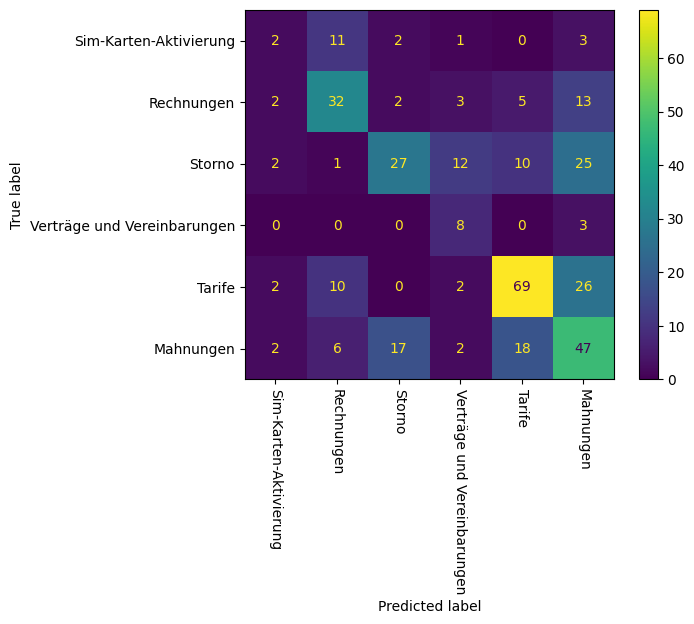

In [ ]:
display_confusion_matrix(predicted, actual, ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"])

## Zero-shot classification using <a href="https://huggingface.co/dbmdz/german-gpt2">German GPT-2</a>

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("dbmdz/german-gpt2")

model = AutoModelWithLMHead.from_pretrained("dbmdz/german-gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1509: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
from transformers import pipeline

german_gpt2_classifier = pipeline(
    'zero-shot-classification',
    model='dbmdz/german-gpt2',
    tokenizer='dbmdz/german-gpt2'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at dbmdz/german-gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [ ]:
predicted, actual = predict_label_full_dataset(
    ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"],
    german_gpt2_classifier
)

In [ ]:
calculate_accuracy(predicted, actual)

'21%'